0_methods_A_neph.ipynb  
# Data processing of nepheloid-layer measurements

**Notebook input:**
- gardner18po_fig2a.asc (from obsdir)
- gardner18po_fig3c.asc (from obsdir)
- runs: CTRL & Px1_14SV (from modeldir)

**Notebook output (written to savedir):**
- Fig. S1
- world_41x40.neph_mask.nc: file with nepheloid layers, suitable for Bern3D model

**Notebook comments:**  
- We regrid the nepheloid-layer data to the Bern3D model grid and fill the data gaps, because the model needs a value everywhere.
- We use nepheloid-layer particle mass and thickness from Gardner et al. 2018 Progress in Oceanography:

   - Wilford D. Gardner, Mary Jo Richardson, Alexey V. Mishonov, and Pierre E.Biscaye.  Global comparison of benthic nepheloid layers based on 52 years of nephelometer and transmissometer measurements. Progress in Oceanography,168(May):100–111, 2018. ISSN 00796611. https://doi.org/10.1016/j.pocean.2018.09.008  
- Waiting time: running all cells of this notebook takes 3 minutes on my laptop.  

**General information:**
- This notebook was published in the zenodo repository https://doi.org/10.5281/zenodo.10622403 along with the paper:

   - Jeemijn Scheen, Jörg Lippold, Frerk Pöppelmeier, Finn Süfke and Thomas F. Stocker. Promising regions for detecting the overturning circulation in Atlantic 231Pa/230Th: a model-data comparison. Paleoceanography and Paleoclimatology, 2025.
- Code author for this notebook: Jeemijn Scheen
- Data authors for this notebook: Alexey Mishonov, Wilford Gardner and Mary Jo Richardson provided the data behind their figures 2a and 3c (i.e., the filenames in *Notebook input*).

# Set up notebook

**Easiest:** load conda environment for which this notebook worked.  
**Just use environment.yml (present in this folder) and follow** https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file

In [1]:
from pathlib import Path         # Path objects to avoid inter-platform trouble in file paths
import platform

########## SET FILE PATHS ######################################
# KEEP THE Path() FUNCTION AND USE FORWARD SLASHES '/' ON EVERY OPERATING SYSTEM
savedir = Path('./figures/')      # folder for saving figures & other output; (empty) directory needed
obsdir = Path('./data/')          # obs. data is loaded from here
modeldir = Path('./modeloutput/') # model output is loaded from here
#############################################

## CHECK FILEPATHS
# expand paths because np.loadtxt can't handle home directory ~
savedir = savedir.expanduser()
obsdir = obsdir.expanduser()
modeldir = modeldir.expanduser()
def check_dir(path):
    if not path.exists():
        raise Exception('File path ' + str(path) + ' does not exit. Correct or create first.')
check_dir(savedir)
check_dir(obsdir)
check_dir(modeldir)

## IMPORT PACKAGES
# first time install missing packages via $conda install numpy OR $pip3 install numpy (be consistent)
import numpy as np
import xarray as xr                            # $conda install -c anaconda -n cartopy xarray; needs some time
import pandas as pd
import importlib as imp                        # to import user-defined functions; renaming new name to name of deprecated package 'imp'
import math                                    # math.e or math.exp()
import xesmf as xe                             # regridding; install via conda-forge channel e.g. !conda install -c conda-forge xesmf -y

# plot-related packages:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace
import matplotlib.cm as cmp                    # colormaps
import cmcrameri.cm as cmcr                    # better colour maps (https://www.fabiocrameri.ch/colourmaps/); $conda install -c conda-forge cmcrameri
import cartopy.crs as ccrs
import seaborn as sns

## CHECK PYTHON VERSION
if 1/2 == 0:
    raise Exception("You are using python 2. Please use python 3 for a correct display of the figures.") 

## PLOT SETTINGS
# larger labels
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## LOAD USER-DEFINED FUNCTIONS
import functions as f                          # my own functions; call via f.function_name()

In [2]:
imp.reload(f)   # shows how to reload functions after editing functions.py w/o kernel restart

<module 'functions' from '/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py'>

In [3]:
## LOAD MODEL GRID (needed for filling data gaps & plotting)
# load 2 example runs; only the model grid is used
ctrl = 'CTRL_NEWNR'
PFX1__14SV = 'PFX1__14SV'
runs = [ctrl, PFX1__14SV] 
spinup_yr = 1765
[datas, data_fulls] = f.load_data_multiple_runs(modeldir, runs, spinup_yr)

# create Bern3D land mask
[xu, yu, land_mask_surf] = f.get_landmask(data_fulls[runs[0]])
X_land, Y_land = np.meshgrid(xu, yu) # u grid because pcolor needs left bottom corner

# Load data

In [4]:
########################################################################
# load data and convert to numpy
########################################################################

## load files of Gardner et al. Fig. 2a & Fig. 3c
files = ['gardner18po_fig2a.asc', 'gardner18po_fig3c.asc']
nr_rows_expected = [171, 169]                                # for checking

# loop over the two files
for i in [0,1]: 
   print('Reading in file:', files[i])
   file = open(obsdir / files[i], mode="r")
   input_per_line = file.read().split('\n')
   this_file_metadata = input_per_line[0:6]  # first 6 lines are meta-data
   print('Metadata of this file:\n', this_file_metadata)
   this_file_data = input_per_line[6:-1]     # omit 6 lines of meta-data; then 1 empty line at the end (stripped off here)
   file.close()
   del file

   ## convert to numpy float array
   assert len(this_file_data) == nr_rows_expected[i], "this_file_data should have "+str(nr_rows_expected[i])+" lines"
   # split each line (1 string) into its columns:
   this_file_data = [row.split(' ') for row in this_file_data]
   assert len(this_file_data[0]) == 361, "this_file_data[0] should have 361 columns"
   assert len(this_file_data[-1]) == 361, "this_file_data[-1] should have 361 columns"
   this_file_data = np.asarray(this_file_data, dtype='float')

   ## replace nans
   this_file_data[this_file_data == 1.7014100000000001E+038] = np.nan
   assert len(this_file_data[this_file_data > 1.0E+038]) == 0, "this_file_data still contains too large values"

   ## save in better variable names, which are used throughout this notebook
   if i == 0:
      fig_2a_metadata = this_file_metadata
      fig_2a_data = this_file_data
   else:
      fig_3c_metadata = this_file_metadata
      fig_3c_data = this_file_data
   del this_file_data, this_file_metadata

########################################################################
# adjust data to have periodic boundaries
########################################################################
# From the given grid, one expects that data column at longitude=-180.5 exactly equals the data column at lon=179.5. But no:
# print('\nFar left and right columns (lon -180.5 and 179.5) are not equal! First 10 rows:')
# print(fig_2a_data[:,(0,-1)][0:10])
# Apparently the intra-/extrapolation was done without periodic boundary conditions or the radius didn't extend to the other side properly.
# In our target Bern3D grid we have no double column with repeated data so we want to delete 1 column anyway for the regridding to work.  

# 1) simply average columns at longitude -180.5 and 179.5
fig_2a_column_averaged = np.nanmean(fig_2a_data[:,(0,-1)], axis=1)  # nan & nan => nan;    nan & value => value;    value & value => avg value
fig_3c_column_averaged = np.nanmean(fig_3c_data[:,(0,-1)], axis=1)

# 2) fill the result in the column at 179.5
fig_2a_data[:,fig_2a_data.shape[1]-1] = fig_2a_column_averaged      # fill average into lon 179.5
fig_3c_data[:,fig_3c_data.shape[1]-1] = fig_3c_column_averaged

# 3) delete the column at -180.5
fig_2a_data = np.delete(fig_2a_data, 0, 1)
fig_3c_data = np.delete(fig_3c_data, 0, 1)
    
# print('\nWe filled their average into lon=179.5 and deleted column lon=-180.5\n')
# print('Check first 10 rows of right column at 179.5: \n', fig_2a_data[:,-1][0:10])

########################################################################
# now convert numpy to xarray (because xarray has coordinates included)
########################################################################
# construct T-grid with 1-degree resolution
lon_t = np.arange(-179.5, 180, 1)
lat_t_fig_2a = np.arange(89.5, -81, -1)  # reading in files from top (line 1) to bottom follows latitude axis from N to S
lat_t_fig_3c = np.arange(89.5, -79, -1)

# construct U-grid; only needed for surface plots with pcolourmesh etc, which wants corners
lon_u = np.arange(-180,180.5)
lat_u_fig_2a = np.arange(90, -81.5, -1)
lat_u_fig_3c = np.arange(90, -79.5, -1)

## now change them to have same lat_t coord
# prepare 2 empty rows to extend lat_fig_3c from -78.5 to -80.5 N; 
empty_rows = np.full((2, len(lon_t)),np.nan)
fig_3c_data_extended = np.vstack([empty_rows, fig_3c_data])

lat_t = lat_t_fig_2a
lat_u = lat_u_fig_2a
gardner_data_xr = xr.Dataset(data_vars={'fig_2a_data': (['lat_t','lon_t'], fig_2a_data),  
                                        'fig_3c_data': (['lat_t','lon_t'], fig_3c_data_extended)}, 
                             coords={'lon_t': (['lon_t'], lon_t),
                                     'lat_t': (['lat_t'], lat_t),
                                     'lon_u': (['lon_u'], lon_u),
                                     'lat_u': (['lat_u'], lat_u),
                                    })

# WARNINGS shown because averaging [np.nan, np.nan] for some rows (fine; nan where land or data gap)

Reading in file: gardner18po_fig2a.asc
Metadata of this file:
 ['ncols 361', 'nrows 171', 'xllcorner -180.5', 'yllcorner -80.5', 'cellsize 1', 'nodata_value 1.7014100000000001E+038']
Reading in file: gardner18po_fig3c.asc
Metadata of this file:
 ['ncols 361', 'nrows 169', 'xllcorner -180.5', 'yllcorner -78.5', 'cellsize 1', 'nodata_value 1.7014100000000001E+038']


<ipython-input-4-9147a5c27c4f>:51: RuntimeWarning: Mean of empty slice
  fig_2a_column_averaged = np.nanmean(fig_2a_data[:,(0,-1)], axis=1)  # nan & nan => nan;    nan & value => value;    value & value => avg value
<ipython-input-4-9147a5c27c4f>:52: RuntimeWarning: Mean of empty slice
  fig_3c_column_averaged = np.nanmean(fig_3c_data[:,(0,-1)], axis=1)


**Explanation of metadata (printed above):**
- xllcorner and yllcorner: lower left corner of x (longitude) and y (latitude)
- grid cell size is 1x1 degree
- 361 columns of longitude => combined with xllcorner we know this is **from -180.5 to 179.5 E in steps of 1 degree**. 
- **Fig 2a:** 171 rows of latitude with yllcorner at -80.5 => **from -80.5 to 89.5 N in steps of 1 degree.**
- **Fig 3c:** 169 rows of latitude with yllcorner at -78.5 => **from -78.5 to 89.5 N in steps of 1 degree.**
- 1.7014100000000001E+038 means NaN value; i.e. land or missing data  

In [5]:
gardner_data_xr  # show resulting xarray dataset

<xarray.Dataset>
Dimensions:      (lat_t: 171, lon_t: 360, lon_u: 361, lat_u: 172)
Coordinates:
  * lon_t        (lon_t) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat_t        (lat_t) float64 89.5 88.5 87.5 86.5 ... -77.5 -78.5 -79.5 -80.5
  * lon_u        (lon_u) float64 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
  * lat_u        (lat_u) float64 90.0 89.0 88.0 87.0 ... -78.0 -79.0 -80.0 -81.0
Data variables:
    fig_2a_data  (lat_t, lon_t) float64 nan nan nan nan ... 37.21 38.6 38.27
    fig_3c_data  (lat_t, lon_t) float64 nan nan nan nan ... 201.9 164.1 223.0

# Regrid

[Background information on regridding from NCAR.](https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview)  

The input grid at hand is regular (1x1 degree) and the Bern3d model grid is rectilinear. Bilinear and inverse distance weighting (IDW) seem the best candidates. But IDW takes into account all grid cells in the weight, not only neighbours. Bilinear takes only neighbours (i.e., the 4 grid cells of the 1x1 grid surrounding the center of the Bern3D target cell in our 2D lat-lon) so I prefer that, because local data should stay local.

We use the [xesmf package](https://pypi.org/project/xesmf/), which depends on ESMPy.

In [6]:
# define input model grid for regridder (Gardner data):
ds_in = gardner_data_xr.rename({'lat_t': 'lat', 'lon_t': 'lon'})  # dataset must include coords named 'lon' and 'lat'


# define output model grid for regridder (Bern3D T-grid): 
lon1 = np.arange(105, 250, 10)
lon2 = np.arange(254, 290, 8)
lon3 = np.arange(293.5, 375, 7)
lon4 = np.asarray([378, 386])
lon5 = np.arange(395, 460, 10)
lon_b3d = np.concatenate([lon1, lon2, lon3, lon4, lon5])

lat1 = np.asarray([-85])
lat2 = np.arange(-78, -40, 4)
lat3 = np.arange(-37.5, -15, 5)
lat4 = np.arange(-13.5, 15, 3)
lat5 = np.arange(17.5, 80, 5)
lat6 = np.asarray([85])
lat_b3d = np.concatenate([lat1, lat2, lat3, lat4, lat5, lat6])

# grid of output dataset
ds_grid_out = xr.Dataset({'lat': (['lat'], lat_b3d),
                          'lon': (['lon'], lon_b3d),
                         })

# create regridder 
regridder = xe.Regridder(ds_in, ds_grid_out, method='bilinear', periodic=True)
print(regridder)  # print basic regridder information

ds_out = regridder(ds_in)  # regrid the entire dataset (contains the 2 variables of fig 2a and 3c)
ds_out = ds_out.rename({'lon': 'lon_t', 'lat': 'lat_t'})  # convert names back to contain info that on T-grid

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_171x360_40x41_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (171, 360) 
Output grid shape:          (40, 41) 
Periodic in longitude?      True


# Fill data gaps 

The regridded data will be loaded in the Bern3D model and needs a value for every non-land (lon,lat).  
So we need to fill the data gaps by some value for the model to run.  
Most regions seem close to zero, except that in majority of Southern Ocean unclear whether should be close to zero or high.  

We take the following approach:  
- each white cell surrounded by 4 neighbours (ignoring diagonal) is filled with the average value of those 4
- this is repeated, as the newly filled cells can surround others
- each remaining white cell surrounded by 3 neighbours is filled with the average of those 3
- this is repeated
- the same with 2 neighbours
- and with 1 neighbour
- handle the north pole

In the iteration we need to ignore land & take periodic boundary conditions into account.

In [7]:
def step_fill_if_n_neighbours(var, n, print_info=True):
    """Fills each nan non-land cell that is surrounded by n non-nan neighbours (ignoring diagonal) 
    with the average value of those n. Neighbours are defined as vertical or horizontal so in total 4. 
    Assumes Bern3D grid.

    Input: 
    - xarray datavar of variable
    - int n gives number of neighbours that need to be filled to fill a data gap. Can be 4,3,2 or 1.
    - print_info. Hardcoded below is also the option print_info_even_more
    Output: 
    [var_out, counter]
    - new xarray datavar with filled cells as described above
    - counter of how many cells were filled. If this is 0, you can stop steps with this n. """
    
    print_info_even_more = False
    
    if n not in [1,2,3,4]:
        raise Exception("n must be 4,3,2 or 1.")
    
    counter = 0     # counts how many cells are filled
    lon = var.lon_t
    lat = var.lat_t
    
    var_result = var.copy(deep=True)  # don't want to alter original var

    for i,x in enumerate(lon):      # i=0 at lon 105 and i=40 at lon 455
        for j,y in enumerate(lat):  # j=0 at -85 and j=39 at 85 N
            
            ## are we indeed in a data gap?
            # only proceed if cell is a data gap (nan)
            if not np.isnan(var_result.isel(lon_t=i, lat_t=j)):
                # cell is not nan so already filled with actual data
                continue
            # discard if cell is on land
            if land_mask_surf.isel(lon_t=i, lat_t=j).item() == 0:
                continue
            if print_info_even_more:
                print('@i,j=',i,j)
    
            ## find neighbours
            # define neighbours in cases for grid boundaries
            if i == 0:
                # periodic boundary condition
                if j==0:
                    # lower left corner
                    nbs = [(0,1),(1,0),(40,0),(0,39)]   # neighbours
                elif j==39:
                    # upper left corner
                    nbs = [(0,38),(1,39),(0,0),(40,39)]
                else:
                    # edge
                    nbs = [(40,j),(i+1,j),(i,j-1),(i,j+1)]
            elif i == 40:
                # periodic boundary condition
                if j==0:
                    # lower right corner
                    nbs = [(39,0),(40,1),(0,0),(40,39)]
                elif j==39:
                    # upper right corner
                    nbs = [(40,38),(39,39),(0,39),(40,0)]
                else:
                    # edge
                    nbs = [(i-1,j),(0,j),(i,j-1),(i,j+1)]
            elif j == 0:
                # lowest row (Antarctica); edge
                nbs = [(i-1,j),(i+1,j),(i,j+1)]
            elif j == 39:
                # highest row (Arctic); edge
                nbs = [(i-1,j),(i+1,j),(i,j-1)]
            else:    
                # normal case: interior with 4 neighbours
                nbs = [(i-1,j),(i+1,j),(i,j-1),(i,j+1)]
            if print_info_even_more:
                print('nbs incl land:', nbs)
            # drop any neighbours that are on land
            nbs = [(i_nb,j_nb) for (i_nb,j_nb) in nbs
                   if land_mask_surf.isel(lon_t=i_nb, lat_t=j_nb).item() != 0] # if land_mask 0 then on land            
            if print_info_even_more:
                print('nbs excl land:', nbs)
            if len(nbs) == 0:
                if print_info_even_more:
                    print('no nbs left')
                continue

            ## investigate neighbours
            nb_vals = np.asarray([var_result.isel(lon_t=i_nb,lat_t=j_nb) for (i_nb,j_nb) in nbs])
            assert len(nb_vals) <= 4, "something went wrong: number of neighbours > 4"
            # how many nan values (data gaps) are present in the remaining neighbours?
            nr_nan_nbs = len([True for x in nb_vals if np.isnan(x).all()]) # .all() because tuples give (False,False)
            if len(nb_vals) == nr_nan_nbs:
                if print_info_even_more:
                    print('no non-nan nbs left')
                continue
            # for n=4 we allow no nan values; for n=3 we allow 1 nan value;for n=2 we allow 2; for n=1 we allow 3
            # summarized we allow 4-n nan values but not > 4-n
            if nr_nan_nbs > (4-n):
                if print_info_even_more:
                    print('too many neighbours were nan; skip')
                continue

            ## fill cell
            nb_avg = np.nanmean(nb_vals)
            var_result.loc[dict(lon_t=x, lat_t=y)] = nb_avg
            counter += 1
            if print_info_even_more:
                print('@i,j=',i,j,'; nbs:', nbs)
            if print_info:
                print('filled cell with', n, 'neighbours @i,j=',i,j,'with value ',round(nb_avg,1))
                    
    print(counter, 'cells were filled in this step with n=', n)
        
    return [var_result, counter]

In [8]:
## TAKES A WHILE (e.g. 1 minute) ##### 

# start with this datavar and update on the way (i.e. fill more and more data gaps)
data_var = ds_out.fig_3c_data.copy(deep=True)
total_counter = 0

# fill data gaps that have 4 neighbours with values (or being land)
# we loop because on the way filled data gaps can be new neighbours to other data gaps
nr_cells_filled = -1
while(nr_cells_filled != 0):
    [data_var, nr_cells_filled] = step_fill_if_n_neighbours(data_var, n=4)
    total_counter += nr_cells_filled
    
# fill data gaps that have 3 neighbours with values 
nr_cells_filled = -1
while(nr_cells_filled != 0):
    [data_var, nr_cells_filled] = step_fill_if_n_neighbours(data_var, n=3)
    total_counter += nr_cells_filled

# fill data gaps that have 2 neighbours with values
nr_cells_filled = -1
while(nr_cells_filled != 0):
    [data_var, nr_cells_filled] = step_fill_if_n_neighbours(data_var, n=2)
    total_counter += nr_cells_filled

# fill data gaps that have 1 neighbour with values
nr_cells_filled = -1
while(nr_cells_filled != 0):
    [data_var, nr_cells_filled] = step_fill_if_n_neighbours(data_var, n=1)
    total_counter += nr_cells_filled

fig_3c_data_def = data_var

print('TOTAL cells filled:', total_counter)
print('finished')

filled cell with 4 neighbours @i,j= 3 22 with value  0.0
filled cell with 4 neighbours @i,j= 3 31 with value  108.5
filled cell with 4 neighbours @i,j= 7 8 with value  85.1
filled cell with 4 neighbours @i,j= 7 10 with value  99.4
filled cell with 4 neighbours @i,j= 8 26 with value  0.2
filled cell with 4 neighbours @i,j= 8 30 with value  69.8
filled cell with 4 neighbours @i,j= 9 8 with value  18.9
filled cell with 4 neighbours @i,j= 9 39 with value  525.2
filled cell with 4 neighbours @i,j= 11 26 with value  1.8
filled cell with 4 neighbours @i,j= 14 9 with value  2.4
filled cell with 4 neighbours @i,j= 18 22 with value  0.0
filled cell with 4 neighbours @i,j= 21 32 with value  2820.0
filled cell with 4 neighbours @i,j= 29 32 with value  358.3
filled cell with 4 neighbours @i,j= 31 21 with value  77.4
filled cell with 4 neighbours @i,j= 34 14 with value  589.7
15 cells were filled in this step with n= 4
0 cells were filled in this step with n= 4
filled cell with 3 neighbours @i,j= 2 

Total number of filled cells is 194. Counting by hand we have 198 data gaps for fig 3c. This seems right up to counting mistakes.  
Now we repeat for the other variable:  

In [9]:
## TAKES A WHILE (e.g. 2 minutes) ##### 
# repeat for other data variable (has more data gaps, that are also further from 0)

# start with this datavar and update on the way (i.e. fill more and more data gaps)
data_var = ds_out.fig_2a_data.copy(deep=True)
total_counter = 0

# fill data gaps that have 4 neighbours with values (or being land)
# we loop because on the way filled data gaps can be new neighbours to other data gaps
nr_cells_filled = -1
while(nr_cells_filled != 0):
    [data_var, nr_cells_filled] = step_fill_if_n_neighbours(data_var, n=4)
    total_counter += nr_cells_filled
    
# fill data gaps that have 3 neighbours with values 
nr_cells_filled = -1
while(nr_cells_filled != 0):
    [data_var, nr_cells_filled] = step_fill_if_n_neighbours(data_var, n=3)
    total_counter += nr_cells_filled

# fill data gaps that have 2 neighbours with values
nr_cells_filled = -1
while(nr_cells_filled != 0):
    [data_var, nr_cells_filled] = step_fill_if_n_neighbours(data_var, n=2)
    total_counter += nr_cells_filled

# fill data gaps that have 1 neighbour with values
nr_cells_filled = -1
while(nr_cells_filled != 0):
    [data_var, nr_cells_filled] = step_fill_if_n_neighbours(data_var, n=1)
    total_counter += nr_cells_filled

fig_2a_data_def = data_var

print('TOTAL cells filled:', total_counter)
print('finished')

filled cell with 4 neighbours @i,j= 0 19 with value  181.2
filled cell with 4 neighbours @i,j= 11 16 with value  2.8
filled cell with 4 neighbours @i,j= 11 30 with value  15.6
filled cell with 4 neighbours @i,j= 13 32 with value  106.8
filled cell with 4 neighbours @i,j= 20 8 with value  57.4
filled cell with 4 neighbours @i,j= 21 32 with value  354.2
filled cell with 4 neighbours @i,j= 22 12 with value  194.8
filled cell with 4 neighbours @i,j= 23 13 with value  114.5
filled cell with 4 neighbours @i,j= 24 17 with value  6.0
filled cell with 4 neighbours @i,j= 25 12 with value  66.0
filled cell with 4 neighbours @i,j= 28 14 with value  19.4
filled cell with 4 neighbours @i,j= 29 32 with value  125.1
filled cell with 4 neighbours @i,j= 36 24 with value  7.7
filled cell with 4 neighbours @i,j= 37 13 with value  155.1
14 cells were filled in this step with n= 4
0 cells were filled in this step with n= 4
filled cell with 3 neighbours @i,j= 1 18 with value  170.2
filled cell with 3 neighbo

# Fig. S1  
Needs the above (i.e., regridding & filling data gaps).

In [10]:
# explore result
print('mean thickness [m]:\t\t',fig_2a_data_def.mean().item())
print('mean excess PM conc [ug/cm2]:\t',fig_3c_data_def.mean().item())

mean thickness [m]:		 89.45566546824172
mean excess PM conc [ug/cm2]:	 268.7844677494577


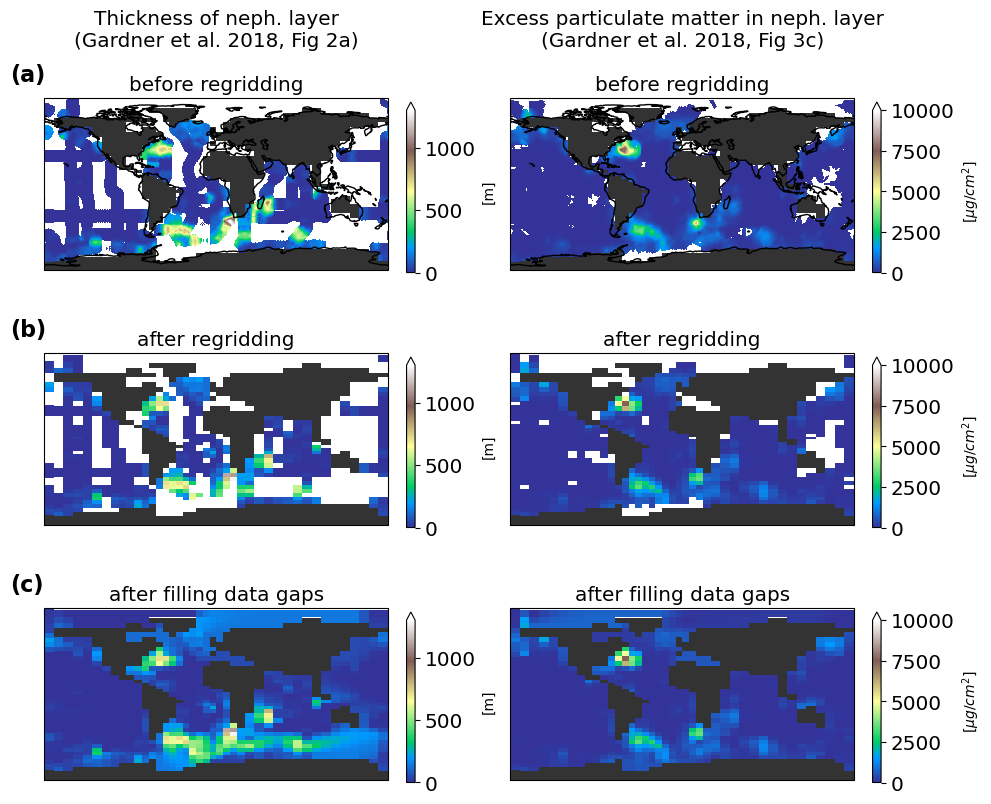

In [11]:
## combined plot of regridding and filling data gaps

## SETTINGS ##############################
small_file = False     # small_file plot is faster; reduces file size by rasterizing panels a); text and axes remain vector
alpha_b3d = 1.0
## END OF SETTINGS #######################

fig, ax = plt.subplots(3,2,figsize=(10,9),
                      subplot_kw={'projection': ccrs.PlateCarree()})

ax[0,0].set_title('Thickness of neph. layer\n(Gardner et al. 2018, Fig 2a)\n\nbefore regridding')
cpf = ax[0,0].pcolormesh(gardner_data_xr.lon_t, gardner_data_xr.lat_t, gardner_data_xr.fig_2a_data.values, 
                         cmap=cmp.terrain, vmin=0, vmax=1300, rasterized=small_file)
fig.colorbar(cpf, ax=ax[0,0], label='[m]', fraction=0.023, extend='max')
ax[0,0].coastlines()

ax[0,1].set_title('Excess particulate matter in neph. layer\n(Gardner et al. 2018, Fig 3c)\n\nbefore regridding')
cpf = ax[0,1].pcolormesh(gardner_data_xr.lon_t, gardner_data_xr.lat_t, gardner_data_xr.fig_3c_data.values,
                         cmap=cmp.terrain, vmin=0, vmax=10000, rasterized=small_file)
fig.colorbar(cpf, ax=ax[0,1], label=r'[$\mu g/cm^2$]', fraction=0.023, extend='max')
ax[0,1].coastlines()

ax[1,0].set_title('after regridding')
cpf = ax[1,0].pcolormesh(ds_out.lon_t, ds_out.lat_t, ds_out.fig_2a_data.values, 
                         cmap=cmp.terrain, vmin=0, vmax=1300)
fig.colorbar(cpf, ax=ax[1,0], label='[m]', fraction=0.023, extend='max')

ax[1,1].set_title('after regridding')
cpf = ax[1,1].pcolormesh(ds_out.lon_t, ds_out.lat_t, ds_out.fig_3c_data.values, 
                         cmap=cmp.terrain, vmin=0, vmax=10000)
fig.colorbar(cpf, ax=ax[1,1], label=r'[$\mu g/cm^2$]', fraction=0.023, extend='max')

ax[2,0].set_title('after filling data gaps')
cpf = ax[2,0].pcolormesh(ds_out.lon_t, ds_out.lat_t, fig_2a_data_def.values, 
                         cmap=cmp.terrain, vmin=0, vmax=1300)
fig.colorbar(cpf, ax=ax[2,0], label='[m]', fraction=0.023, extend='max')

ax[2,1].set_title('after filling data gaps')
cpf = ax[2,1].pcolormesh(ds_out.lon_t, ds_out.lat_t, fig_3c_data_def.values, 
                         cmap=cmp.terrain, vmin=0, vmax=10000)
fig.colorbar(cpf, ax=ax[2,1], label=r'[$\mu g/cm^2$]', fraction=0.023, extend='max')

for i in [0,1,2]:
    for j in [0,1]:
        ax[i,j].set_ylim(-90,90)   # extends to Antarctica
        ax[i,j].pcolormesh(X_land, Y_land, land_mask_surf.values, cmap='Greys', vmin=-0.5, vmax=0.1, alpha=alpha_b3d)
    # add (a), (b) etc. 
    ax[i,0].text(-0.1, 1.1, '(' + chr(ord('a')+i) + ')', transform=ax[i,0].transAxes, 
                 size=16, weight='bold')
        
plt.tight_layout(h_pad=-3.0)  # default is 1.08; somehow the cbars take the amount of space as before fraction

if small_file:
    plt.savefig(savedir / 'figS1_gardner_combined_small.pdf', dpi=400)
    # src: https://www.astrobetter.com/blog/2014/01/17/slim-down-your-bloated-graphics/ and a bit of
    # https://stackoverflow.com/questions/10685495/reducing-the-size-of-pdf-figure-file-in-matplotlib
else:
    plt.savefig(savedir / 'figS1_gardner_combined.pdf')

# Export as .nc suitable for Bern3D model

In [12]:
## rename variable names to be suitable for the model code
# /1000: convert neph_PM from ug/cm2 to mg/cm2 (as is assumed in the code) s.t. numbers are closer to 1
ds_result = xr.Dataset(data_vars={'neph_thickness': (['lat_t','lon_t'], fig_2a_data_def.data,
                                                     {'units': 'm', 'long_name': "Thickness of nepheloid layer in m", 
                                                      'standard_name': "thickness of nepheloid layer in m",
                                                      'reference': 'Gardner et al. 2018 Progress in Oceanography, Fig. 2a; regridded; data gaps filled'}),
                                  'neph_PM': (['lat_t','lon_t'], fig_3c_data_def.data / 1000.0,
                                             {'units': 'mg/cm2', 'long_name': "Excess Particulate Matter of nepheloid layer in mg/cm2 (summed over water column)", 
                                              'standard_name': "nepheloid particulate matter in mg/cm2", 
                                              'reference': 'Gardner et al. 2018 Progress in Oceanography, Fig. 3c; regridded; data gaps filled'})},
                       coords={'lon_t': (['lon_t'], fig_2a_data_def.lon_t.data,
                                        {'units': "degrees_east", 'long_name': "Longitude", 'standard_name': "longitude", 'axis': "X"}),
                               'lat_t': (['lat_t'], fig_2a_data_def.lat_t.data,
                                        {'units': "degrees_north", 'long_name': "Latitude", 'standard_name': "latitude", 'axis': "Y"}),
                               'lon_u': (['lon_u'], data_fulls[runs[0]].lon_u.data,
                                        {'units': "degrees_east", 'long_name': "Longitude", 'standard_name': "longitude", 'axis': "X"}),
                               'lat_v': (['lat_v'], data_fulls[runs[0]].lat_u.data,
                                        {'units': "degrees_north", 'long_name': "Latitude", 'standard_name': "latitude", 'axis': "Y"}),
                              },
                       attrs={'created': '19 August 2021'})
# save
ds_result.to_netcdf(savedir / 'world_41x40.neph_mask.nc')